# Donor deconvolution

Examples of using vireoSNP for donor deconvolution.

**Please use the command line in [manual](https://vireosnp.readthedocs.io/en/latest/manual.html)**. This notebooks is mainly for development and diagnosis.

In [1]:
import vireoSNP
import numpy as np

from scipy import sparse
from scipy.io import mmread

## Load cellSNP data 

##### Option 1 - VCF format

In [2]:
cell_vcf = vireoSNP.load_VCF("../data/cells.cellSNP.vcf.gz", biallelic_only=True)
cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])

AD = cell_dat['AD']
DP = cell_dat['DP']

##### Option 2 - sparse matrices

In [3]:
AD = mmread("../data/cellSNP_mat/cellSNP.tag.AD.mtx").tocsc()
DP = mmread("../data/cellSNP_mat/cellSNP.tag.DP.mtx").tocsc()

Note, `AD` and `DP` are sparse matrices, not `numpy.array`

## Run Vireo
For donor deconvolution, the `vireoSNP.vireo_wrap` function can be directly used, which contains multiple initialization and have options for different situtaions of donor genotype, fully missing, partially lack, or all available.

In [4]:
res = vireoSNP.vireo_wrap(AD, DP, n_donor=4, learn_GT=True,
                          n_extra_donor=0, ASE_mode=False, fix_beta_sum=False,
                          n_init=50, check_doublet=True, random_seed=1)

[vireo] lower bound ranges [-29456.1, -25592.6, -19155.3]
[vireo] allelic rate mean and concentrations:
[[0.017 0.462 0.941]]
[[28199.7 38020.2 21634.1]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2	donor3
241	246	234	231


##### The donor assignment probability

In [5]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(2, 2.5), dpi=200)

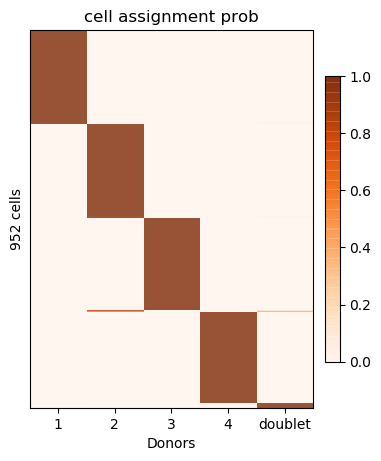

In [6]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(4, 5), dpi=100)
# assign_prob_comb = res['ID_prob']
assign_prob_comb = np.append(res['ID_prob'], 
                             np.sum(res['doublet_prob'], axis=1, 
                                    keepdims=True), axis=1)
im = heat_matrix(assign_prob_comb, 
                 cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("cell assignment prob")
plt.xlabel("Donors")
plt.ylabel("%d cells" %(res['ID_prob'].shape[0]))
plt.yticks([])
plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, "doublet"])

# plt.tight_layout()
plt.show()

In [7]:
## donor id with highest probability
donor_ids_best = np.argmax(res['ID_prob'], axis=1)

In [8]:
## doublet rate

doublet_threshold = 0.9
is_doublet = np.sum(res['doublet_prob'], axis=1) > doublet_threshold
print("%d cells are called doublet" %(sum(is_doublet)))

prob_threshold = 0.9
is_unassigned = (np.max(res['ID_prob'], axis=1) < prob_threshold) & (~is_doublet)
print("%d cells are unassigned to singlet or doublets" %(sum(is_unassigned)))

13 cells are called doublet
4 cells are unassigned to singlet or doublets


### Allelic ratio per variant per donor

In [9]:
## If ASE_mode is False
AF_SNPs = np.tensordot(res['GT_prob'], res['theta_mean'][0, :], axes=[2, 0])

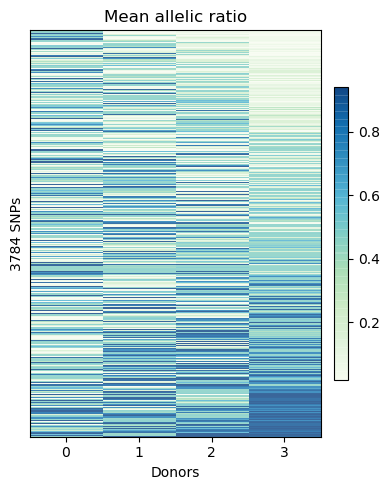

In [10]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(4, 5), dpi=100)
im = heat_matrix(AF_SNPs, cmap="GnBu", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Donors")
plt.ylabel("%d SNPs" %(AF_SNPs.shape[0]))
plt.yticks([])
plt.xticks([0, 1, 2, 3])

plt.tight_layout()
plt.show()

## Choose the number of donors

Unsually, the number of donors are known. In case you are not sure on this, you could try a set of numbers, e.g., from 2 to 6 here, and pick the one when the evidence lower bound (ELBO) stops increasing, e.g., 
[Figure 2A in Vireo paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1865-2/figures/2)

In this data set, `n_donor=4` is a sensible choice.

In [11]:
n_donor_list = np.arange(2, 7)
ELBO_list_all = []
for _n_don in n_donor_list:
    res = vireoSNP.vireo_wrap(AD, DP, n_donor=_n_don, learn_GT=True,
                              n_extra_donor=0, ASE_mode=False, fix_beta_sum=False,
                              n_init=50, check_doublet=True, random_seed=1)
    ELBO_list_all.append(res['LB_list'])

[vireo] lower bound ranges [-42583.3, -34775.1, -33917.3]
[vireo] allelic rate mean and concentrations:
[[0.064 0.437 0.849]]
[[24679.1 40819.5 22355.4]]
[vireo] donor size before removing doublets:
donor0	donor1
483	469
[vireo] lower bound ranges [-33921.1, -27814.6, -25535.5]
[vireo] allelic rate mean and concentrations:
[[0.026 0.445 0.91 ]]
[[25407.2 40997.2 21449.6]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2
241	242	469
[vireo] lower bound ranges [-29456.1, -25592.6, -19155.3]
[vireo] allelic rate mean and concentrations:
[[0.017 0.462 0.941]]
[[28199.7 38020.2 21634.1]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2	donor3
241	246	234	231
[vireo] lower bound ranges [-29997.3, -24381.9, -18709.2]
[vireo] allelic rate mean and concentrations:
[[0.019 0.457 0.929]]
[[28304.3 37007.5 22542.2]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2	donor3	donor4
51	233	223	236	209
[vireo] lower bound ranges [-28605.3, -23995.5, -19

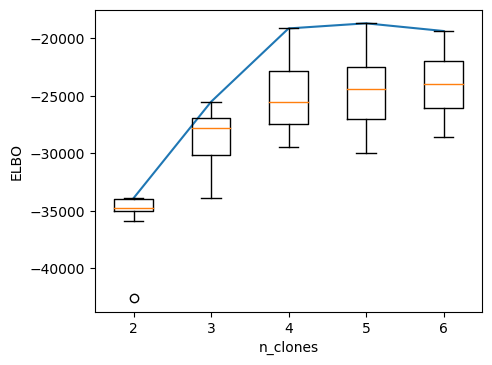

In [12]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(5, 4), dpi=100)
plt.plot(n_donor_list - 1, np.max(ELBO_list_all, axis=1))
plt.boxplot(ELBO_list_all)
plt.xticks(n_donor_list - 1, n_donor_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()